In [286]:
import calendar
from calendar import day_name
import numpy as np
import pandas as pd
import seaborn as sns
palette_color = sns.color_palette('pastel')
from datetime import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

pd.set_option('display.max_column', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_seq_items', 100)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None

In [287]:
df = pd.read_csv('Test.csv - test.csv')

In [288]:
df.shape, df.order_id_new.nunique(), df.order_try_id_new.nunique()

((4943, 26), 4166, 4166)

In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4943 entries, 0 to 4942
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id_new           4943 non-null   int64  
 1   order_try_id_new       4943 non-null   int64  
 2   calc_created           4943 non-null   object 
 3   metered_price          4923 non-null   float64
 4   upfront_price          3409 non-null   float64
 5   distance               4943 non-null   int64  
 6   duration               4943 non-null   int64  
 7   gps_confidence         4943 non-null   int64  
 8   entered_by             4943 non-null   object 
 9   b_state                4943 non-null   object 
 10  dest_change_number     4943 non-null   int64  
 11  prediction_price_type  4923 non-null   object 
 12  predicted_distance     4923 non-null   float64
 13  predicted_duration     4923 non-null   float64
 14  change_reason_pricing  298 non-null    object 
 15  tick

In [290]:
df = df.drop(columns=['device_token'])

In [291]:
df.order_id_new.nunique()

4166

In [292]:
### Handle and remove duplicate - Take count of order_try_id_new, ticket_id_new and 1 if overpaid ride ticket

df = df.drop(columns=['order_try_id_new', 'ticket_id_new', 'overpaid_ride_ticket']).drop_duplicates().merge(df.groupby(['order_id_new']).agg({'order_try_id_new': 'nunique', 'ticket_id_new': 'nunique', 'overpaid_ride_ticket': 'sum'}).reset_index(), how='left')

In [293]:
df.shape

(4166, 25)

In [294]:
df = df.drop(columns=['rider_app_version', 'driver_app_version'])

In [295]:
def func(x):
    x = x.replace("-", " ")
    x = x.replace("_", " ")
    if 'iPhone' in x:
        x = x[:6] + ' ' + x[6:]
    if len(x) == 1:
        model = ''
    else:
        manufacturer = x.split(' ')[0]
        model = ' '.join(x.split(' ')[1:])
    if 'INFINIX' in x:
        if len(x.split(' ')) > 4:
            manufacturer = "Infinix"
            model = " ".join(x.split(" ")[4:])
    if 'TECNO' in x:
        if len(x.split(' ')) > 4:
            # print(x)
            manufacturer = "TECNO"
            model = " ".join(x.split(" ")[4:])
    if 'HMD' in x:
        manufacturer = "Nokia"
        if len(x.split(' ')) > 3:
            model = " ".join(x.split(" ")[3:])
    if manufacturer in ["ITEL", "Itel"]:
        manufacturer = "ITEL"
    return manufacturer, model
    
df['device_manufacturer'], df['device_model'] = zip(*df.device_name.apply(lambda x: func(x)))

In [296]:
df.device_manufacturer.value_counts(1).head(10)

device_manufacturer
Samsung    0.349496
TECNO      0.172348
HUAWEI     0.154105
iPhone     0.088094
Xiaomi     0.053769
Infinix    0.049688
Nokia      0.039846
ITEL       0.023524
Sony       0.010082
LGE        0.007921
Name: proportion, dtype: float64

In [297]:
df.device_model.value_counts(1)

device_model
F3               0.023284
B1p              0.018723
2.2              0.018723
8,1              0.018243
MAR LX1A         0.015122
                   ...   
Redmi 3S         0.000240
Moto G (5)       0.000240
LA6              0.000240
BLADE A506       0.000240
Redmi Note 5A    0.000240
Name: proportion, Length: 495, dtype: float64

In [298]:
df.b_state.value_counts()

b_state
finished    4166
Name: count, dtype: int64

In [299]:
df.order_try_state.value_counts()

order_try_state
finished    4166
Name: count, dtype: int64

In [300]:
df.order_state.value_counts()

order_state
finished    4165
active         1
Name: count, dtype: int64

In [301]:
df.drop(columns=['device_name', 'b_state', 'order_state', 'order_try_state'], inplace=True)

In [302]:
df.entered_by.value_counts()

entered_by
client      3972
driver       189
reseller       5
Name: count, dtype: int64

In [304]:
df.change_reason_pricing.value_counts()

change_reason_pricing
driver_destination_changed    127
client_destination_changed    123
driver_waypoint_changed         5
Name: count, dtype: int64

In [306]:
df.prediction_price_type.value_counts()

prediction_price_type
upfront                        2967
prediction                      998
upfront_destination_changed     179
upfront_waypoint_changed          3
Name: count, dtype: int64

In [308]:
df.calc_created.min(), df.calc_created.max()

('2020-02-02 0:01:16', '2020-03-13 9:44:45')

In [309]:
df['transaction_date'] = pd.to_datetime(df['calc_created'])
df['transaction_weekday'] = df['transaction_date'].dt.weekday
df['transaction_weekday'] = df['transaction_weekday'].apply(lambda x: calendar.day_name[x])
df = df.drop(columns=['transaction_date'])

In [310]:
df['percentage_change_in_upfront_price'] = 100 * (np.abs(df.upfront_price - df.metered_price) / df.upfront_price)
df['percentage_change_in_upfront_price'].quantile([0.1,0.25,0.5,0.75,0.9,0.95,0.99])

0.10      1.136364
0.25      4.412824
0.50     16.306312
0.75     33.955151
0.90     63.336397
0.95     94.664645
0.99    254.348841
Name: percentage_change_in_upfront_price, dtype: float64

In [311]:
# All Transactions
len(df)

4166

In [312]:
# Upfront pricing used
up_df = df[df.prediction_price_type == 'upfront']
len(up_df), 100 * (len(up_df) / len(df))

(2967, 71.21939510321651)

In [313]:
highchange_up_df = up_df[up_df['percentage_change_in_upfront_price'] > 20]
len(highchange_up_df), 100 * (len(highchange_up_df) / len(up_df)), 100 * (len(highchange_up_df) / len(df))

(1346, 45.36568924839906, 32.30916946711474)

In [314]:
lowchange_up_df = up_df[up_df['percentage_change_in_upfront_price'] <= 20]
len(lowchange_up_df), 100 * (len(lowchange_up_df) / len(up_df)), 100 * (len(lowchange_up_df) / len(df))

(1600, 53.92652510953826, 38.40614498319731)

In [315]:
missing_up_df = up_df[up_df.percentage_change_in_upfront_price.isna()]
len(missing_up_df), 100 * (len(missing_up_df) / len(up_df)), 100 * (len(missing_up_df) / len(df))

(21, 0.7077856420626896, 0.5040806529044647)

In [316]:
# Metered pricing used
met_df = df[df.prediction_price_type != 'upfront']
len(met_df), 100 * (len(met_df) / len(df))

(1199, 28.780604896783483)

In [317]:
len(highchange_up_df)

1346

In [318]:
highchange_up_df.percentage_change_in_upfront_price.median(), highchange_up_df.percentage_change_in_upfront_price.mean(), highchange_up_df.percentage_change_in_upfront_price.mode()[0]


(36.63522012578616, 57.75933501683072, 25.0)

In [375]:
highchange_up_df[((highchange_up_df['distance'] == 0) | (highchange_up_df['duration'] == 0))].percentage_change_in_upfront_price.mean()

56.90515654166824

In [319]:
100 * len(highchange_up_df[((highchange_up_df['distance'] == 0) | (highchange_up_df['duration'] == 0))]) / len(highchange_up_df)

2.0059435364041605

In [343]:
highchange_up_df['percentage_change_distance_pred'] = 100 * (np.abs(highchange_up_df.distance - highchange_up_df.predicted_distance) / highchange_up_df.distance)
highchange_up_df[highchange_up_df['percentage_change_distance_pred'] != np.inf]['percentage_change_distance_pred'].quantile([0.1,0.25,0.5,0.75,0.9,0.95,0.99])

0.10         8.900659
0.25        20.747289
0.50        32.628002
0.75        55.116711
0.90       333.817191
0.95      2943.562006
0.99    100011.642857
Name: percentage_change_distance_pred, dtype: float64

In [346]:
highchange_up_df['percentage_change_duration_pred'] = 100 * (np.abs(highchange_up_df.duration - highchange_up_df.predicted_duration) / highchange_up_df.duration)
highchange_up_df[highchange_up_df['percentage_change_distance_pred'] != np.inf]['percentage_change_duration_pred'].quantile([0.1,0.25,0.5,0.75,0.9,0.95,0.99])

0.10        9.044267
0.25       22.234228
0.50       37.524950
0.75       60.236384
0.90      150.476734
0.95      667.140497
0.99    10767.136364
Name: percentage_change_duration_pred, dtype: float64

In [368]:
highchange_up_df['distance_bin'] = pd.qcut(highchange_up_df.distance, 10, labels=False)
highchange_up_df['duration_bin'] = pd.qcut(highchange_up_df.duration, 10, labels=False)
distance_data = highchange_up_df.groupby(['distance_bin']).agg({'order_id_new': np.size, 'upfront_price': np.mean, 'metered_price': np.mean, 'percentage_change_in_upfront_price': np.mean}).reset_index()
distance_data[distance_data.order_id_new > 10].sort_values('percentage_change_in_upfront_price', ascending=False)

,distance_bin,order_id_new,upfront_price,metered_price,percentage_change_in_upfront_price
9,9,135,15090.682222,35510.293111,152.772586
8,8,134,10045.756716,11558.648582,70.784470
0,0,135,6584.846667,2800.784667,56.498519
5,5,135,1896.668148,2264.623481,47.822466
7,7,135,10938.643704,5187.158296,46.956237
6,6,134,2091.042537,2331.864627,42.991431
4,4,134,2391.691791,2325.329776,40.850195
2,2,134,2619.098507,1223.146642,40.345564
1,1,135,2414.615556,975.479333,39.428561
3,3,135,959.435556,838.261333,38.876168


In [385]:
len(highchange_up_df[highchange_up_df.distance_bin > 7]) / len(highchange_up_df)

0.199851411589896

In [373]:
highchange_up_df[highchange_up_df.distance_bin > 7].percentage_change_in_upfront_price.mean()

111.93092195239467

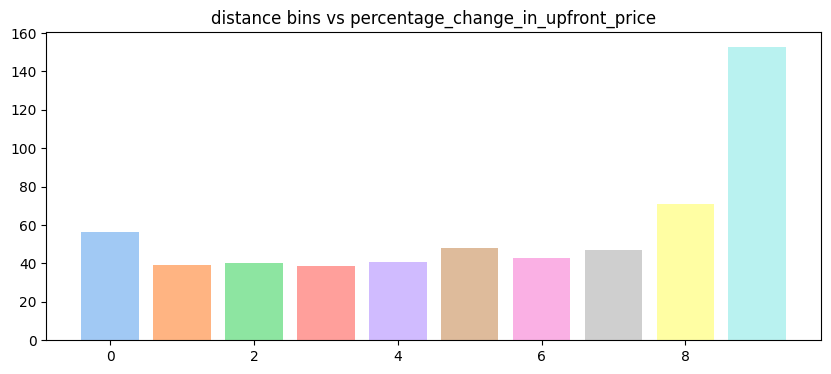

In [262]:
data = distance_data.percentage_change_in_upfront_price.values.tolist()
keys = distance_data.distance_bin.values.tolist()
plt.bar(x=keys, height=data, color=palette_color)
plt.title("distance bins vs percentage_change_in_upfront_price")
plt.show()

In [263]:
duration_data = highchange_up_df.groupby(['duration_bin']).agg({'order_id_new': np.size, 'upfront_price': np.mean, 'metered_price': np.mean, 'percentage_change_in_upfront_price': np.mean}).reset_index()
duration_data[duration_data.order_id_new > 10].sort_values('percentage_change_in_upfront_price', ascending=False)

,duration_bin,order_id_new,upfront_price,metered_price,percentage_change_in_upfront_price
9,9,135,16751.158519,33650.105926,138.347154
8,8,134,10851.356716,13882.268731,85.301316
7,7,133,6351.524060,4758.081729,55.485726
0,0,135,5559.296296,2284.514667,53.984589
5,5,135,1778.857778,2431.347852,46.551526
4,4,134,7299.402239,2822.802836,43.790640
6,6,136,2111.920588,2794.369559,42.940622
1,1,136,1944.666912,921.456176,39.321596
3,3,134,1123.347761,989.429701,38.096855
2,2,134,1350.755970,529.996716,33.763133


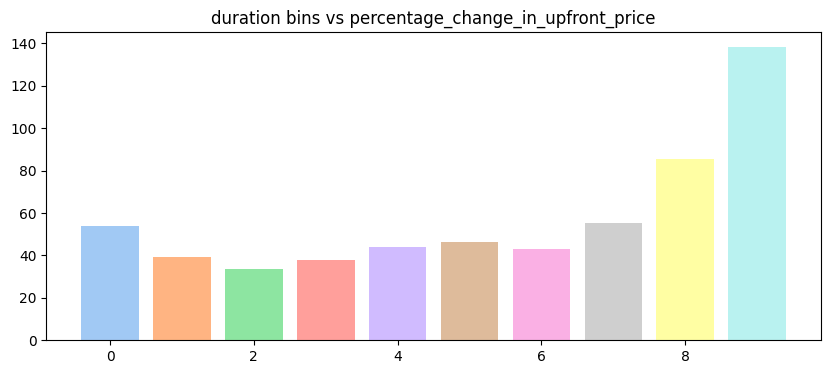

In [264]:
data = duration_data.percentage_change_in_upfront_price.values.tolist()
keys = duration_data.duration_bin.values.tolist()
plt.bar(x=keys, height=data, color=palette_color)
plt.title("duration bins vs percentage_change_in_upfront_price")
plt.show()

In [370]:
len(highchange_up_df[highchange_up_df.duration_bin > 7]) / len(highchange_up_df)

2009

In [374]:
highchange_up_df[highchange_up_df.duration_bin > 7].percentage_change_in_upfront_price.mean()

111.92283297840973

In [265]:
weekday_data = highchange_up_df.groupby(['transaction_weekday']).agg({'metered_price': np.sum, 'percentage_change_in_upfront_price': np.mean}).reset_index()
weekday_data['transaction_weekday'] = pd.Categorical(weekday_data['transaction_weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
weekday_data = weekday_data.sort_values('transaction_weekday')
weekday_data

,transaction_weekday,metered_price,percentage_change_in_upfront_price
1,Monday,1521612.37,57.148726
5,Tuesday,1017909.51,56.895221
6,Wednesday,620614.34,51.696888
4,Thursday,777779.30,46.319135
0,Friday,1518404.72,52.465502
2,Saturday,1334355.45,69.649958
3,Sunday,1968989.95,71.300661


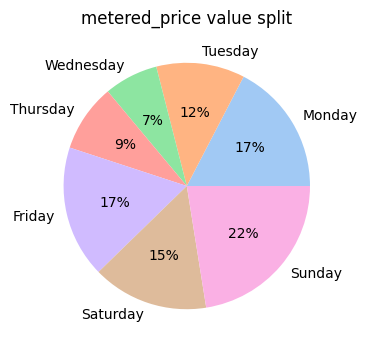

In [266]:
data = weekday_data.metered_price.values.tolist()
keys = weekday_data.transaction_weekday.values.tolist()
plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
plt.title("metered_price value split")
plt.show()

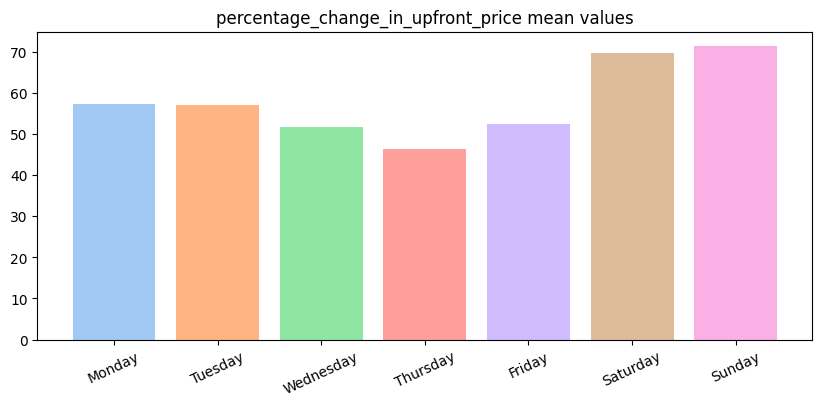

In [272]:
data = weekday_data.percentage_change_in_upfront_price.values.tolist()
keys = weekday_data.transaction_weekday.values.tolist()
plt.bar(height=data, x=keys, color=palette_color)
plt.title("percentage_change_in_upfront_price mean values")
plt.xticks(rotation=25)
plt.show()

In [383]:
len(highchange_up_df[highchange_up_df.transaction_weekday.isin(['Saturday', 'Sunday'])]) / len(highchange_up_df)

0.274888558692422

In [376]:
weekday_data[weekday_data.transaction_weekday.isin(['Saturday', 'Sunday'])].percentage_change_in_upfront_price.mean()

70.47530941451708

In [389]:
device_data = highchange_up_df.groupby(['device_manufacturer']).agg({'order_id_new': np.size, 'upfront_price': np.mean, 'metered_price': np.mean, 'percentage_change_in_upfront_price': np.mean}).reset_index()
device_data = device_data[device_data.order_id_new > 10].sort_values('percentage_change_in_upfront_price', ascending=False)
device_data

,device_manufacturer,order_id_new,upfront_price,metered_price,percentage_change_in_upfront_price
29,TECNO,173,16430.635838,21802.813584,94.942012
15,ITEL,25,12320.000000,14710.950000,88.342027
21,Nokia,43,6805.251163,13048.983488,73.209046
16,Infinix,50,14890.000000,18942.610000,64.654962
27,Sony,12,5.650000,7.745000,54.664394
33,Xiaomi,85,640.680000,1564.589059,54.253908
19,LGE,12,4796.800000,5951.677500,53.622818
35,iPhone,139,1207.041727,1976.069928,52.540372
26,Samsung,492,5253.941260,4019.362459,48.089519
12,HUAWEI,253,545.584980,1232.654980,47.176267


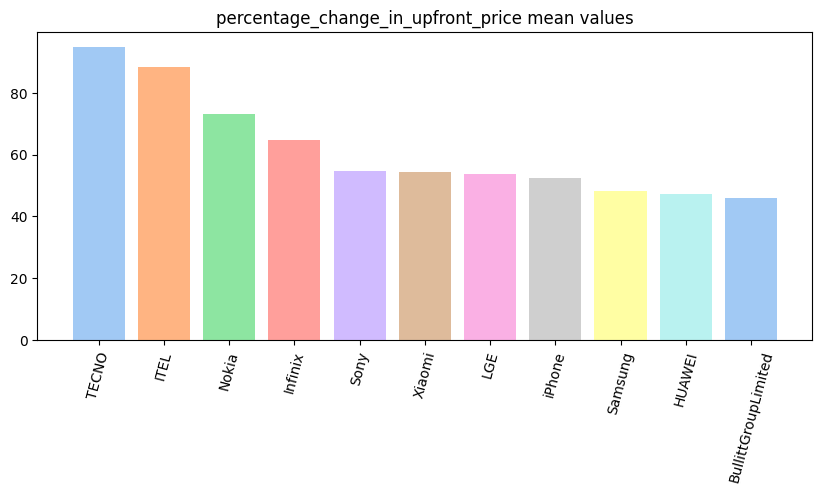

In [390]:
data = device_data.percentage_change_in_upfront_price.values.tolist()
keys = device_data.device_manufacturer.values.tolist()
plt.bar(height=data, x=keys, color=palette_color)
plt.title("percentage_change_in_upfront_price mean values")
plt.xticks(rotation=75)
plt.rcParams["figure.figsize"] = (10,4)
plt.show()

In [391]:
len(highchange_up_df[highchange_up_df.device_manufacturer.isin(['ITEL', 'TECNO', 'Nokia', 'Infinix'])]) / len(highchange_up_df)

0.2161961367013373

In [392]:
device_data[device_data.device_manufacturer.isin(['ITEL', 'TECNO', 'Nokia', 'Infinix'])].percentage_change_in_upfront_price.mean()

80.28701182089921

In [393]:
device_data = highchange_up_df.groupby(['device_model']).agg({'order_id_new': np.size, 'upfront_price': np.mean, 'metered_price': np.mean, 'percentage_change_in_upfront_price': np.mean}).reset_index()
device_data = device_data[device_data.order_id_new > 20].sort_values('percentage_change_in_upfront_price', ascending=False)
device_data.head(2)

,device_model,order_id_new,upfront_price,metered_price,percentage_change_in_upfront_price
41,B1p,35,14542.857143,29053.392286,162.815162
200,SM A520F,26,621.000000,386.977308,47.098900


In [394]:
len(highchange_up_df[highchange_up_df.device_model.isin(['B1p', 'SM A520F'])]) / len(highchange_up_df)

0.045319465081723624

In [395]:
device_data[device_data.device_model.isin(['B1p', 'SM A520F'])].percentage_change_in_upfront_price.mean()

104.95703075264055

In [357]:
ticket_id_new = highchange_up_df.groupby(['ticket_id_new']).agg({'order_id_new': np.size, 'upfront_price': np.mean, 'metered_price': np.mean, 'percentage_change_in_upfront_price': np.mean}).reset_index()
ticket_id_new = ticket_id_new[ticket_id_new.order_id_new > 20].sort_values('percentage_change_in_upfront_price', ascending=False)
ticket_id_new.head(2)

,ticket_id_new,order_id_new,upfront_price,metered_price,percentage_change_in_upfront_price
2,3,28,11287.585714,15207.081071,107.079185
1,2,137,6445.081022,9487.447518,64.287202


In [350]:
eu_indicator = highchange_up_df.groupby(['eu_indicator']).agg({'order_id_new': np.size, 'upfront_price': np.mean, 'metered_price': np.mean, 'percentage_change_in_upfront_price': np.mean}).reset_index()
eu_indicator = eu_indicator[eu_indicator.order_id_new > 20].sort_values('percentage_change_in_upfront_price', ascending=False)
eu_indicator.head(2)

,eu_indicator,order_id_new,upfront_price,metered_price,percentage_change_in_upfront_price
0,0,381,19439.632546,22972.559869,91.523013
1,1,965,5.945492,7.378580,44.428805


In [396]:
len(highchange_up_df[highchange_up_df.eu_indicator.isin([0])]) / len(highchange_up_df)

0.28306092124814264

In [398]:
eu_indicator[eu_indicator.eu_indicator.isin([0])].percentage_change_in_upfront_price.mean()

91.52301267555555

In [353]:
gps_confidence = highchange_up_df.groupby(['gps_confidence']).agg({'order_id_new': np.size, 'upfront_price': np.mean, 'metered_price': np.mean, 'percentage_change_in_upfront_price': np.mean}).reset_index()
gps_confidence = gps_confidence[gps_confidence.order_id_new > 20].sort_values('percentage_change_in_upfront_price', ascending=False)
gps_confidence.head(2)

,gps_confidence,order_id_new,upfront_price,metered_price,percentage_change_in_upfront_price
0,0,206,16632.111165,26951.245291,126.853718
1,1,1140,3496.510965,2813.779921,45.273859


In [399]:
len(highchange_up_df[highchange_up_df.gps_confidence.isin([0])]) / len(highchange_up_df)

0.15304606240713226

In [400]:
gps_confidence[gps_confidence.gps_confidence.isin([0])].percentage_change_in_upfront_price.mean()

126.85371788871053

In [352]:
overpaid_ride_ticket = highchange_up_df.groupby(['overpaid_ride_ticket']).agg({'order_id_new': np.size, 'upfront_price': np.mean, 'metered_price': np.mean, 'percentage_change_in_upfront_price': np.mean}).reset_index()
overpaid_ride_ticket = overpaid_ride_ticket[overpaid_ride_ticket.order_id_new > 20].sort_values('percentage_change_in_upfront_price', ascending=False)
overpaid_ride_ticket.head(2)

,overpaid_ride_ticket,order_id_new,upfront_price,metered_price,percentage_change_in_upfront_price
1,1,65,15623.833846,23873.768000,110.037541
0,0,1278,4976.281847,5494.505931,54.553655


In [401]:
len(highchange_up_df[highchange_up_df.overpaid_ride_ticket.isin([1])]) / len(highchange_up_df)

0.048291233283803865

In [402]:
overpaid_ride_ticket[overpaid_ride_ticket.overpaid_ride_ticket.isin([1])].percentage_change_in_upfront_price.mean()

110.03754070463287

In [354]:
dest_change_number = highchange_up_df.groupby(['dest_change_number']).agg({'order_id_new': np.size, 'upfront_price': np.mean, 'metered_price': np.mean, 'percentage_change_in_upfront_price': np.mean}).reset_index()
dest_change_number = dest_change_number[dest_change_number.order_id_new > 20].sort_values('percentage_change_in_upfront_price', ascending=False)
dest_change_number.head(2)

,dest_change_number,order_id_new,upfront_price,metered_price,percentage_change_in_upfront_price
2,3,39,6300.766667,9280.998205,83.953812
1,2,23,48197.295652,21647.422174,67.475504


In [424]:
len(highchange_up_df[highchange_up_df.fraud_score.isna()]) / len(highchange_up_df)

0.4086181277860327

In [412]:
highchange_up_df['fraud_bin'] = pd.qcut(highchange_up_df.fraud_score, 10, labels=False)
fraud_score = highchange_up_df.groupby(['fraud_bin']).agg({'order_id_new': np.size, 'upfront_price': np.mean, 'metered_price': np.mean, 'percentage_change_in_upfront_price': np.mean}).reset_index()
fraud_score = fraud_score[fraud_score.order_id_new > 10].sort_values('percentage_change_in_upfront_price', ascending=False)
fraud_score.head(2)

,fraud_bin,order_id_new,upfront_price,metered_price,percentage_change_in_upfront_price
8,8.0,75,105.613333,237.201467,50.359021
2,2.0,79,5.445570,7.106203,45.198331


<Axes: xlabel='fraud_score', ylabel='Density'>

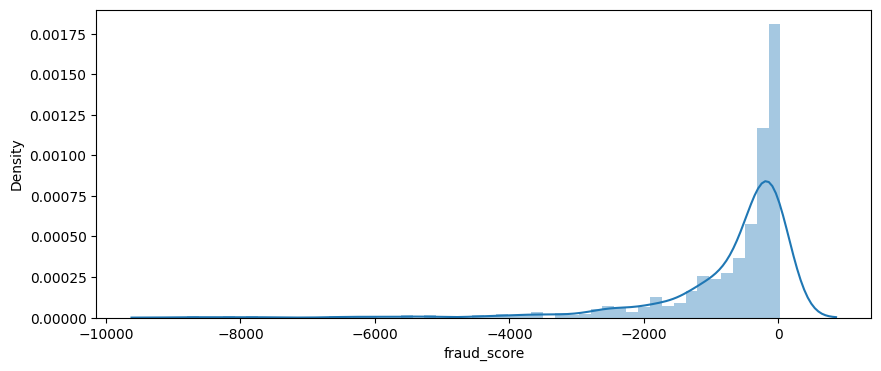

In [408]:
sns.distplot(highchange_up_df.fraud_score)

In [409]:
highchange_up_df.fraud_score.quantile([0.1, 0.25, 0.5, 0.75, 0.9])

0.10   -1850.00
0.25    -890.25
0.50    -294.00
0.75     -89.00
0.90      -5.50
Name: fraud_score, dtype: float64

In [416]:
highchange_up_df[highchange_up_df.fraud_bin==2].fraud_score.min(), highchange_up_df[highchange_up_df.fraud_bin==2].fraud_score.max()

(-1084.0, -701.0)

In [404]:
len(highchange_up_df[highchange_up_df.fraud_score.notna()]) / len(highchange_up_df)

0.5913818722139673

In [421]:
cols = ['metered_price', 'upfront_price', 'distance', 'duration', 'gps_confidence', 'predicted_distance', 'predicted_duration', 'eu_indicator',
        'dest_change_number', 'fraud_score', 'percentage_change_in_upfront_price']
df[cols].head()

,metered_price,upfront_price,distance,duration,gps_confidence,predicted_distance,predicted_duration,eu_indicator,dest_change_number,fraud_score,percentage_change_in_upfront_price
0,4.04,10.0,2839,700,1,13384.0,1091.0,1,1,-1383.0,59.600000
1,6.09,3.6,5698,493,1,2286.0,360.0,1,1,NaN,69.166667
2,4.32,3.5,4426,695,1,4101.0,433.0,1,1,-166.0,23.428571
3,72871.72,NaN,49748,1400,0,3017.0,600.0,0,2,NaN,NaN
4,20032.50,19500.0,10273,5067,1,14236.0,2778.0,0,1,NaN,2.730769


<Axes: >

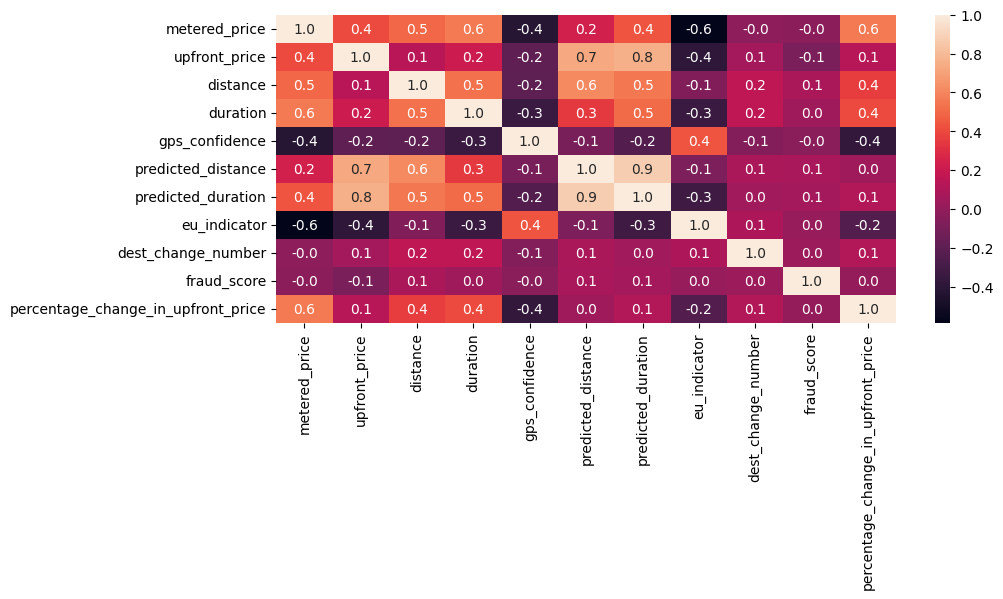

In [422]:
sns.heatmap(df[cols].corr(method ='pearson'), annot=True, fmt='.1f')

In [51]:
df.metered_price.quantile([0.1,0.25,0.5,0.75,0.9,0.95,0.99])

0.10        3.4500
0.25        5.3800
0.50       13.3500
0.75    10991.6700
0.90    22104.4600
0.95    33581.6620
0.99    73460.1088
Name: metered_price, dtype: float64

In [49]:
df.upfront_price.quantile([0.1,0.25,0.5,0.75,0.9,0.95,0.99])

0.10        3.0
0.25        4.2
0.50        6.6
0.75     4000.0
0.90    13500.0
0.95    18500.0
0.99    42960.0
Name: upfront_price, dtype: float64

<Axes: xlabel='metered_price', ylabel='Density'>

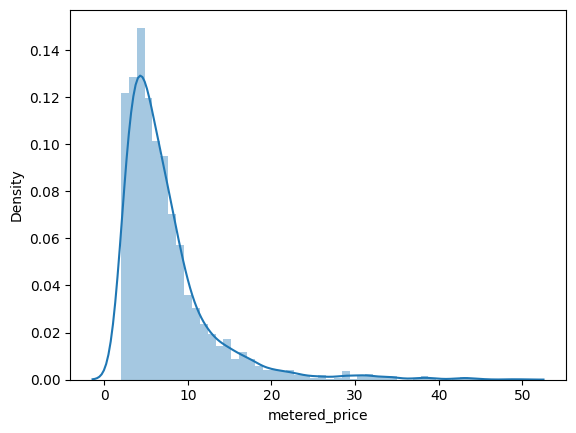

In [61]:
sns.distplot(df[df.metered_price < 50].metered_price)

<Axes: xlabel='upfront_price', ylabel='Density'>

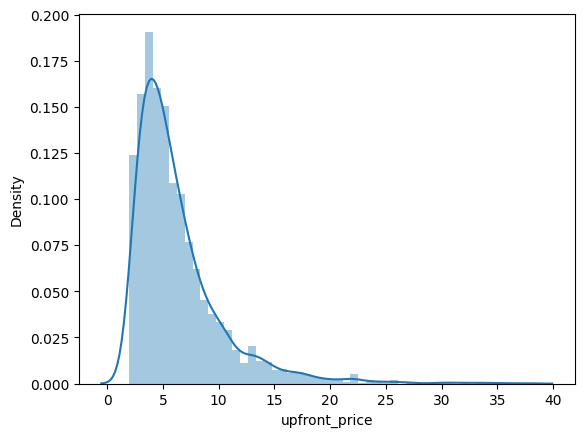

In [60]:
sns.distplot(df[df.upfront_price < 50].upfront_price)

In [63]:
df.metered_price.mean(), df.upfront_price.mean()

(7998.471295957749, 4160.095746553242)

In [58]:
df.metered_price.median(), df.upfront_price.median()

(13.35, 6.6)